# Master overview
This master overview contains all graphs used in the final thesis, to make sure everything was trained and tested on the same data.

In [22]:
# utils
from util import evaluate_no_cv, calculate_auc_and_plot, get_epitope_df, get_features, fix_test, \
    evaluate_seperate_chains, get_columns_starting_with, get_counts, plot_scores

# distance measures
from util import ProximityForestClassifier, calculate_tcr_dist2, calculate_tcr_dist2_cached, calculate_tcr_dist_multiple_chains, calculate_tcr_dist, multi_dist, levenstein_distance, multi_lev, calculate_approx_distance, nan_hamming

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline

# own models
from CustomForest import RandomForest as CustomForest
from util import ProximityForestClassifier, KNNString

# other
import numpy as np
import pandas as pd
from datetime import datetime
import os

# models
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [23]:
models_to_evaluate = []

In [24]:
# train/test data
folds = 5
epitope = "GILGFVFTL"
species = "HomoSapiens"
descr = "distance-models-cdr-hamming"

dataset_size = 50 # typically 50, 100, 200, 500, 1000, 2000, 5000 or None (None = all data)


data_per_fold = []
df_size = 0

def update_data_per_fold(dataset_size, epitope_=None):
    global data_per_fold, df_size, epitope, species, folds

    epitope = epitope_ if epitope_ is not None else epitope

    df = get_epitope_df(epitope, species=species)

    # for fixed test size (during the different size runs when sampling a few instances)
    df, test = train_test_split(df, test_size=0.2, random_state=0)
    test = test.sample(400, random_state=0)
    # test.dropna(inplace=True)
    # split test df into folds
    # test_folds = np.array_split(test, folds)
    # test = test.sample(100, random_state=0)


    df = df.sample(dataset_size, random_state=0) if dataset_size is not None else df
    df_size = len(df)

    data_per_fold = []
    for seed in range(folds):
        fold_data = {"seed": seed,
                     "epitope": epitope,
                     "species": species,
                     "df_size": df_size,}

        train_with_nan, test_with_nan = train_test_split(df, test_size=0.2, random_state=seed)

        # # for fixed test size (during the different size runs)
        # test_with_nan = test_folds[seed] # actually no nan, but no problem
        test_with_nan = test # same test set for all folds


        test = test_with_nan.dropna()

        x_missing = train_with_nan.isna().any(axis=1)

        # with nan in train set
        x = get_features(train_with_nan)
        y = train_with_nan['reaction']

        # print the name of all columns in x that contain nan



        x_missing_test = test_with_nan.isna().any(axis=1)
        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        x_test_missing = x_test.isna().any(axis=1)

        y_test = test['reaction']

        alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(train_with_nan)

        assert len(x) == len(x_missing) == len(y)
        assert len(x_test) == len(x_test_missing) == len(y_test)

        fold_data["nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'x_missing': x_missing,
                            'x_missing_test': x_missing_test, 'x_original': train_with_nan,
                            'x_test_original': test,
                            "train_alpha_only": alpha_only_count_pos, "train_beta_only": beta_only_count_pos,
                            "train_both": both_count_pos, "train_non": non_count_pos, 'train_total': len(x),
                            'test_total': len(x_test)}

        # without nan in train set
        train_without_nan = train_with_nan.dropna()
        x = get_features(train_without_nan)
        y = train_without_nan['reaction']

        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        y_test = test['reaction']

        assert len(x) == len(y)
        assert len(x_test) == len(y_test)

        fold_data["no_nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'train_total': len(x),
                               'test_total': len(x_test), 'train_both': len(train_without_nan), 'train_non': 0, 'x_original': train_without_nan, 'x_test_original': test,
                               'train_alpha_only': 0, 'train_beta_only': 0}

        data_per_fold.append(fold_data)


    # print train and test size for seed 0 (nan and no_nan)
    nan_data = data_per_fold[0]["nan"]
    no_nan_data = data_per_fold[0]["no_nan"]
    print(f"Nan: train: {len(nan_data['x'])}, test: {len(nan_data['x_test'])}")
    print(f"No Nan: train: {len(no_nan_data['x'])}, test: {len(no_nan_data['x_test'])}")

In [25]:
def evaluate_model(model_description):
    """
    model description is a dict with the following keys:
    - name*: name of the model
    - model*: the model
    - imputer: the imputer to use
    - chain: 'both', 'alpha', 'beta' or 'seperate'. In cas of 'seperate', model_alpha and model_beta must be defined instead of model
    - drop_train_na: if True, all rows with nan in the train set are dropped
    - missing_indicator: if True, a missing indicator is added as feature
    - columns_to_use: list of columns to use (CDR, V, J)
    - extract_features: if False, the original columns are used and no features are extracted
    """
    global data_per_fold

    assert "name" in model_description
    assert "model" in model_description

    scores = pd.DataFrame()

    num_folds = len(data_per_fold)
    for i in range(num_folds):

        model_train_nan = not model_description.get("drop_train_na", False)
        data_name = "nan" if model_train_nan else "no_nan"

        chain = model_description.get("chain", "both")
        assert chain in ["both", "alpha", "beta", "seperate"]

        # get the precomputed dataset for this fold (either the version with nan or without nan
        fold_data = data_per_fold[i]
        fold_dataset = fold_data[data_name]
        x = fold_dataset["x"].copy()
        y = fold_dataset["y"].copy()
        x_test = fold_dataset["x_test"].copy()
        y_test = fold_dataset["y_test"].copy()

        columns_to_use = model_description.get("columns_to_use", None)

        extract_features = model_description.get("extract_features", True)

        # set the columns_to_use if only specific gene features are used
        gene_features = model_description.get("gene_features", None)
        if gene_features is not None:
            assert gene_features in ["FV", "F", "V", "F+V", "FV+F+V"] #, "CDR_only"]

            column_map = {'F': ['V_family', 'J_family'],
                          'V': ['V_version', 'J_version'],
                          'FV': ['V', 'J']}
            column_map['F+V'] = column_map['F'] + column_map['V']
            column_map['FV+F+V'] = column_map['FV'] + column_map['F'] + column_map['V']
            # add CDR3 to all
            for key in column_map:
                column_map[key].append('CDR3')

            columns_to_use = column_map[gene_features]


        # if there needs to be other columns or no features need to be extracted, the pre-computed features won't work
        if columns_to_use is None or not extract_features:
            if columns_to_use is None:
                columns_to_use = ["CDR3", "V", "J"]

            # recreate train data
            x_original = fold_dataset["x_original"]
            x_test_original = fold_dataset["x_test_original"]

            x = get_features(x_original, columns=columns_to_use, extract_features=extract_features)

            x_test = get_features(x_test_original, columns=columns_to_use, test=True, extract_features=extract_features)
            x_test = fix_test(x_test, x.columns)
            x_test.dropna(inplace=True)


        # add missing indicator if needed
        missing_indicator = model_description.get("missing_indicator", False)
        if missing_indicator:
            x_missing = fold_dataset["x_missing"]
            x_missing_test = fold_dataset["x_missing_test"]
            x["missing"] = x_missing
            x_test["missing"] = x_missing_test

        # get only alpha or beta chain if needed
        if chain == "alpha" or chain == "beta":
            x = get_columns_starting_with(x, f'{chain}_')
            x_test = get_columns_starting_with(x_test, f'{chain}_')

        model_imputer = model_description.get("imputer", None)

        separate_chains = chain == "seperate"

        try:
            if separate_chains:
                model_alpha = model_description["model_alpha"]
                model_beta = model_description["model_beta"]
                auc = evaluate_seperate_chains(model_alpha, model_beta, x, y, x_test, y_test, model_imputer)
            else:
                model = model_description["model"]
                if model_imputer is not None:
                    model = Pipeline([('imputer', model_imputer), ('model', model)])
                    model_imputer = None
                auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)

            # add the scores to the dataframe
            index = len(scores)
            scores.loc[index, 'model'] = model_description['name']
            scores.loc[index, 'auc'] = auc
            scores.loc[index, 'model_train_nan'] = model_train_nan
            scores.loc[index, 'imputer'] = model_imputer.__class__.__name__ if model_imputer is not None else None
            scores.loc[index, 'chain'] = chain
            scores.loc[index, 'group'] = model_description['group']

            scores.loc[index, 'seed'] = fold_data["seed"]
            scores.loc[index, 'epitope'] = fold_data["epitope"]
            scores.loc[index, 'species'] = fold_data["species"]

            scores.loc[index, 'train_alpha_only'] = fold_dataset["train_alpha_only"]
            scores.loc[index, 'train_beta_only'] = fold_dataset["train_beta_only"]
            scores.loc[index, 'train_both'] = fold_dataset["train_both"]
            scores.loc[index, 'train_non'] = fold_dataset["train_non"]
            scores.loc[index, 'train_total'] = fold_dataset["train_total"]
            scores.loc[index, 'test_total'] = fold_dataset["test_total"]
            scores.loc[index, 'df_size'] = fold_data["df_size"]

            scores.loc[index, 'gene_features'] = gene_features
            scores.loc[index, 'missing_indicator'] = missing_indicator


            # print the row
            # print(scores.loc[index])
            # print(f"AUC(m={model_description['name']}, s={seed}, train_na={int(model_train_nan)}): {auc}")
            print(auc)

        except Exception as e:
            print(f"Error: {e}")
            raise e # for debugging
            continue

    return scores

In [26]:
def evaluate_model_list(models_to_evaluate):
    assert len(models_to_evaluate) > 0, "No models to evaluate"

    start_time = datetime.now()
    timestamp = start_time.strftime("%Y%m%d-%H%M%S")
    # create a directory in outputs to save the files to
    global epitope, df_size, descr
    output_dir = f"outputs/model-evaluations-{timestamp}-{epitope}-{df_size}-{descr}"
    os.makedirs(output_dir, exist_ok=True)

    output_log = f"{output_dir}/log.txt"
    with open(output_log, 'w') as f:
        f.write(f"Started at {start_time}\n\n")
        f.write(f"Models to evaluate: {len(models_to_evaluate)}\n\n")
        for i, model in enumerate(models_to_evaluate):
            f.write(f"{i + 1}/{len(models_to_evaluate)}: {model['name']}\n")
            f.write(f"{model}\n\n")


    scores = pd.DataFrame()
    for i, model in enumerate(models_to_evaluate):
        print(f"\nEvaluating model {i + 1}/{len(models_to_evaluate)}")
        print(model)
        model_scores = evaluate_model(model)

        model_scores['test_nr'] = i + 1
        model_scores.to_csv(f"{output_dir}/{i + 1}-{model['name']}.csv")

        scores = pd.concat([scores, model_scores])
    # write to csv
    end_time = datetime.now()

    time_taken = end_time - start_time
    timestamp = end_time.strftime("%Y%m%d-%H%M%S")
    scores.to_csv(f"{output_dir}/scores-{timestamp}.csv")

    plot_scores(scores, "All models", output_file=f"{output_dir}/all-models.png")

    # create a directory 'groups'
    groups_dir = f"{output_dir}/groups"
    os.makedirs(groups_dir, exist_ok=True)
    # for each group in the scores, save a csv with the scores for that group
    for group in scores['group'].unique():
        group_scores = scores[scores['group'] == group]

        # always add the baseline group
        if group != 'baseline':
            baseline_scores = scores[scores['group'] == 'baseline']
            group_scores = pd.concat([baseline_scores, group_scores])

        group_scores.to_csv(f"{groups_dir}/{group}.csv")
        plot_scores(group_scores, group, output_file=f"{groups_dir}/{group}.png")



    print(f'Finished evaluating {len(models_to_evaluate)} models at {timestamp} in {time_taken} seconds')

    with open(output_log, 'a') as f:
        f.write(f"Finished at {end_time}\n")
        f.write(f"Time taken: {time_taken}\n")
        f.write(f"Saved scores to {output_dir}\n")
        f.write(f"Saved all scores to {output_dir}/scores-{timestamp}.csv\n")
        f.write(f"Saved group scores to {groups_dir}\n")
        f.write(f"Saved all group scores to {groups_dir}/all-models.png\n")
        f.write(f"Saved all models to {output_dir}/all-models.png\n")
        f.write(f"Saved log to {output_log}\n")

    return scores

In [27]:
# imputers
zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
most_freq_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [28]:
%%script echo skipping

# baseline (random forest, nans dropped in train)
baseline = {
    'name': 'Random Forest (NaNs dropped in train)',
    'model': RandomForestClassifier(random_state=0),
    'drop_train_na': True,
    'group': 'baseline',
}
models_to_evaluate.append(baseline)

Couldn't find program: 'echo'


In [29]:
%%script echo skipping

# random forest imputations
rf_zero_imputed = {
    'name': 'Random Forest (Zero imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_mean_imputed = {
    'name': 'Random Forest (Mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'rf_imputations'
}

rf_most_freq_imputed = {
    'name': 'Random Forest (Most frequent imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': most_freq_imputer,
    'group': 'rf_imputations'
}

rf_median_imputed = {
    'name': 'Random Forest (Median imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': median_imputer,
    'group': 'rf_imputations'
}

rf_imputation_models = [rf_zero_imputed, rf_mean_imputed, rf_most_freq_imputed, rf_median_imputed]
models_to_evaluate.extend(rf_imputation_models)

Couldn't find program: 'echo'


In [30]:
%%script echo skipping

# knn imputers
rf_knn_imputed_1 = {
    'name': 'Random Forest (KNN imputed, k=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=1),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_5 = {
    'name': 'Random Forest (KNN imputed, k=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=5),
    'group': 'rf_knn_imputations'
}

rf_knn_imputed_15 = {
    'name': 'Random Forest (KNN imputed, k=10)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.KNNImputer(n_neighbors=10),
    'group': 'rf_knn_imputations'
}

rf_knn_imputation_models = [rf_knn_imputed_1, rf_knn_imputed_5, rf_knn_imputed_15]
models_to_evaluate.extend(rf_knn_imputation_models)

Couldn't find program: 'echo'


In [31]:
%%script echo skipping

# iterative imputations
rf_iterative_imputed_1 = {
    'name': 'Random Forest (Iterative imputed, max_iter=1)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=1),
    'group': 'rf_iterative_imputations'
}

rf_iterative_imputed_5 = {
    'name': 'Random Forest (Iterative imputed, max_iter=5)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': impute.IterativeImputer(max_iter=5),
    'group': 'rf_iterative_imputations'
}

# rf_iterative_imputed_10 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=10)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=10),
#     'group': 'rf_iterative_imputations'
# }
#
# rf_iterative_imputed_15 = {
#     'name': 'Random Forest (Iterative imputed, max_iter=15)',
#     'model': RandomForestClassifier(random_state=0),
#     'imputer': impute.IterativeImputer(max_iter=15),
#     'group': 'rf_iterative_imputations'
# }

# rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5, rf_iterative_imputed_10, rf_iterative_imputed_15]
rf_iterative_imputation_models = [rf_iterative_imputed_1, rf_iterative_imputed_5]
models_to_evaluate.extend(rf_iterative_imputation_models)

Couldn't find program: 'echo'


In [32]:
%%script echo skipping

# knn classifier
knn_classifier_mean_imputed = {
    'name': 'KNN Classifier (mean imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': mean_imputer
}

knn_classifier_knn_imputed = {
    'name': 'KNN Classifier (KNN imputed)',
    'model': KNeighborsClassifier(),
    'group': 'knn',
    'imputer': impute.KNNImputer()
}

knn_models = [knn_classifier_mean_imputed, knn_classifier_knn_imputed]
models_to_evaluate.extend(knn_models)

Couldn't find program: 'echo'


In [33]:
%%script echo skipping

# missing indicator imputations
# same models as above, but with missing indicator
rf_imputation_models_with_missing_indicator = []
for model in rf_imputation_models:
    model_with_missing_indicator = model.copy()
    model_with_missing_indicator['name'] += " (with missing indicator)"
    model_with_missing_indicator['missing_indicator'] = True
    model_with_missing_indicator['group'] = 'rf_imputations_with_missing_indicator'
    rf_imputation_models_with_missing_indicator.append(model_with_missing_indicator)

models_to_evaluate.extend(rf_imputation_models_with_missing_indicator)

Couldn't find program: 'echo'


In [34]:
%%script echo skipping

# gradient boosting classifiers
hist_gradient_boosting = {
    'name': 'HistGradientBoosting',
    'model': HistGradientBoostingClassifier(random_state=0),
    'group': 'gradient_boosting'
}

xgboost = {
    'name': 'XGBoost',
    'model': XGBClassifier(random_state=0),
    'group': 'gradient_boosting'
}

lightgbm = {
    'name': 'LightGBM',
    'model': LGBMClassifier(random_state=0),
    'group': 'gradient_boosting'
}

gradient_boosting_models = [hist_gradient_boosting, xgboost, lightgbm]
models_to_evaluate.extend(gradient_boosting_models)

Couldn't find program: 'echo'


In [35]:
%%script echo skipping

# gene features
features_to_test = ["FV", "F", "V", "F+V", "FV+F+V"]
gene_feature_models = []
for features in features_to_test:
    model = {
        'name': f"Random Forest ({features})",
        'model': RandomForestClassifier(random_state=0),
        'gene_features': features,
        'group': 'gene_features',
        'imputer': mean_imputer,
    }
    gene_feature_models.append(model)

models_to_evaluate.extend(gene_feature_models)

Couldn't find program: 'echo'


In [36]:
%%script echo skipping

# chain inputs
both_chains = {
    'name': 'Random Forest (both chains)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'both',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

alpha_chain = {
    'name': 'Random Forest (Alpha chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'alpha',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

beta_chain = {
    'name': 'Random Forest (Beta chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'beta',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

seperate_chains = {
    'name': 'Random Forest (Seperate chains)',
    'model_alpha': RandomForestClassifier(random_state=0),
    'model_beta': RandomForestClassifier(random_state=0),
    'chain': 'seperate',
    'group': 'chain_inputs',
    'imputer': mean_imputer,
}

chain_input_models = [both_chains, alpha_chain, beta_chain, seperate_chains]
models_to_evaluate.extend(chain_input_models)

Couldn't find program: 'echo'


In [37]:
%%script echo skipping

chain_input_without_nans = []
for model in chain_input_models:
    model_without_nans = model.copy()
    model_without_nans['name'] += " (without nans)"
    model_without_nans['drop_train_na'] = True
    model_without_nans['imputer'] = None
    chain_input_without_nans.append(model_without_nans)
models_to_evaluate.extend(chain_input_without_nans)

Couldn't find program: 'echo'


In [38]:
%%script echo skipping

# WeightedRandomForest
weighted_random_forest = {
    'name': 'RandomForest (own impl., weighted)',
    'model': CustomForest(weighted=True), # doesn't support random state
    'group': 'weighted_random_forest',
}

custom_random_forest = {
    'name': 'RandomForest (own impl.)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'imputer': mean_imputer,
}

# # to check whether it's the same as non-weighted, which is indeed the case
# weighted_random_forest_no_nan = {
#     'name': 'RandomForest (own impl., weighted, no nan)',
#     'model': CustomForest(weighted=True), # doesn't support random state
#     'group': 'weighted_random_forest',
#     'drop_train_na': True,
# }

custom_random_forest_no_nan = {
    'name': 'RandomForest (own impl., no nan)',
    'model': CustomForest(weighted=False),
    'group': 'weighted_random_forest',
    'drop_train_na': True,
}

weighted_random_forest_models = [weighted_random_forest, custom_random_forest, weighted_random_forest_no_nan, custom_random_forest_no_nan]
models_to_evaluate.extend(weighted_random_forest_models)

Couldn't find program: 'echo'


In [39]:
%%script echo skipping

rf_cdr_only = {
    'name': 'RandomForest (only CDR3)',
    'model': RandomForestClassifier(random_state=0),
    'group': 'cdr_only',
    'columns_to_use': ['CDR3'],
    'imputer': mean_imputer,
}

rf_cdr_only_no_nan = {
    'name': 'RandomForest (only CDR3, no nan)',
    'model': RandomForestClassifier(random_state=0),
    'group': 'cdr_only',
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

models_to_evaluate.extend([rf_cdr_only, rf_cdr_only_no_nan])

Couldn't find program: 'echo'


In [40]:
%%script echo skipping

# knn classifier with different distance measures
# knn classifier
knn_tcr_dist_no_nan = {
    'name': 'KNN (tcr_dist, nan_dist=10000, CDR3 only)',
    'model':  KNNString(k=5, metric=calculate_tcr_dist_multiple_chains),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_tcr_dist_0 = {
    'name': 'KNN (tcr_dist, nan_dist=0, CDR3 only)',
    'model':  KNNString(k=5, metric=calculate_tcr_dist_multiple_chains, metric_kwargs={'nan_distance': 0}),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3']
}

knn_lev_dist_no_nan = {
    'name': 'KNN (lev, CDR3 only, no nan)',
    'model':  KNNString(k=5, metric=multi_lev),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

knn_lev_dist_0 = {
    'name': 'KNN (multi_tcr_dist, nan_dist=0, CDR3 only)',
    'model':  KNNString(k=5, metric=multi_lev, metric_kwargs={'nan_distance': 0}),
    'group': 'knn_metrics',
    'extract_features': False,
    'columns_to_use': ['CDR3']
}

models_to_evaluate.extend([knn_tcr_dist_no_nan, knn_tcr_dist_0, knn_lev_dist_no_nan, knn_lev_dist_0])

Couldn't find program: 'echo'


In [41]:
%%script echo skipping

proximity_forest_no_nan = {
    'name': 'ProximityForest (nan_dist=0, measure=tcr_dist)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

proximity_forest_models = [proximity_forest_no_nan]

models_to_evaluate.extend(proximity_forest_models)

Couldn't find program: 'echo'


In [42]:
# %%script echo skipping

# More ProximityForest
# proximity_forest_nan_150 = {
#     'name': 'ProximityForest (nan_dist=150, measure=tcr_dist)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
#                                       distance_kwargs={"nan_distance": 150}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3'],
# }


# proximity_forest_tcr_dist2 = {
#     'name': 'ProximityForest (nan_dist=0, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_tcr_dist2 = {
#     'name': 'ProximityForest (no_nan, measure=tcr_dist2)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_tcr_dist2_approx = {
#     'name': 'ProximityForest (nan_dist, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance, distance_kwargs={'nan_distance': 0}),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }

# proximity_forest_no_nan_tcr_dist2_approx = {
#     'name': 'ProximityForest (no_nan, measure=tcr_approx)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=calculate_approx_distance),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

# proximity_forest_lev = {
#     'name': 'ProximityForest (nan_dist=0, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': False,
# }
#
# proximity_forest_no_nan_lev = {
#     'name': 'ProximityForest (no_nan, measure=lev)',
#     'model': ProximityForestClassifier(reduce_features=False, distance_measure=multi_lev),
#     'group': 'proximity_forest',
#     'extract_features': False,
#     'columns_to_use': ['CDR3', 'V', 'J'],
#     'drop_train_na': True,
# }

proximity_forest_hamm = {
    'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': False,
}

proximity_forest_no_nan_hamm = {
    'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)',
    'model': ProximityForestClassifier(reduce_features=False, distance_measure=nan_hamming),
    'group': 'proximity_forest',
    'extract_features': False,
    'columns_to_use': ['CDR3'],
    'drop_train_na': True,
}

# models_to_evaluate.append(proximity_forest_nan_150)
# models_to_evaluate.append(proximity_forest_tcr_dist2)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2)
# models_to_evaluate.append(proximity_forest_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_no_nan_tcr_dist2_approx)
# models_to_evaluate.append(proximity_forest_lev)
# models_to_evaluate.append(proximity_forest_no_nan_lev)
models_to_evaluate.append(proximity_forest_hamm)
models_to_evaluate.append(proximity_forest_no_nan_hamm)

### Dataset size: 50 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 40, test: 108
No Nan: train: 9, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 165.21it/s]


0.64


Predicting: 100%|██████████| 100/100 [00:00<00:00, 152.64it/s]


0.56


Predicting: 100%|██████████| 100/100 [00:00<00:00, 145.57it/s]


0.63


Predicting: 100%|██████████| 100/100 [00:00<00:00, 145.46it/s]


0.56


Predicting: 100%|██████████| 100/100 [00:00<00:00, 162.60it/s]


0.5700000000000001

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 206.65it/s]


0.62


Predicting: 100%|██████████| 100/100 [00:00<00:00, 290.58it/s]


0.55


Predicting: 100%|██████████| 100/100 [00:00<00:00, 297.90it/s]


0.62


Predicting: 100%|██████████| 100/100 [00:00<00:00, 299.90it/s]


0.55


Predicting: 100%|██████████| 100/100 [00:00<00:00, 231.21it/s]


0.55
Finished evaluating 2 models at 20230527-081411 in 0:00:08.390450 seconds


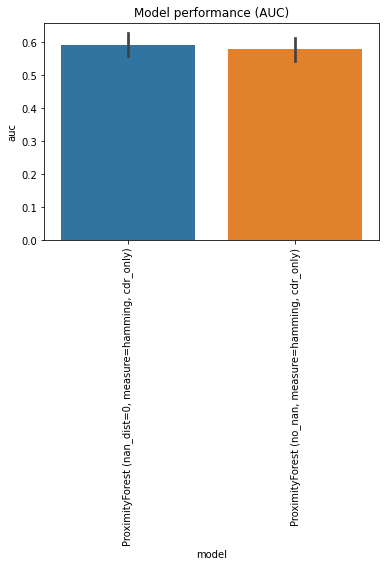

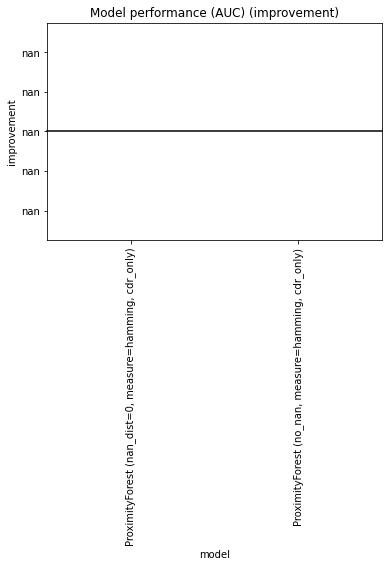

### Dataset size: 100 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 80, test: 108
No Nan: train: 18, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 141.07it/s]


0.6799999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 157.07it/s]


0.65


Predicting: 100%|██████████| 100/100 [00:00<00:00, 149.74it/s]


0.6799999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 162.51it/s]


0.67


Predicting: 100%|██████████| 100/100 [00:00<00:00, 157.80it/s]


0.67

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 160.72it/s]


0.64


Predicting: 100%|██████████| 100/100 [00:00<00:00, 189.41it/s]


0.62


Predicting: 100%|██████████| 100/100 [00:00<00:00, 156.81it/s]


0.64


Predicting: 100%|██████████| 100/100 [00:00<00:00, 183.87it/s]


0.63


Predicting: 100%|██████████| 100/100 [00:00<00:00, 171.24it/s]


0.64
Finished evaluating 2 models at 20230527-081427 in 0:00:11.735580 seconds


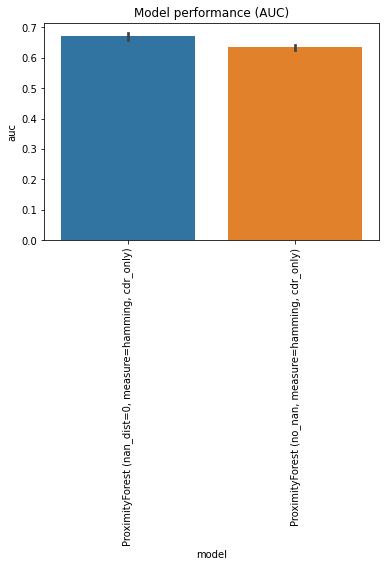

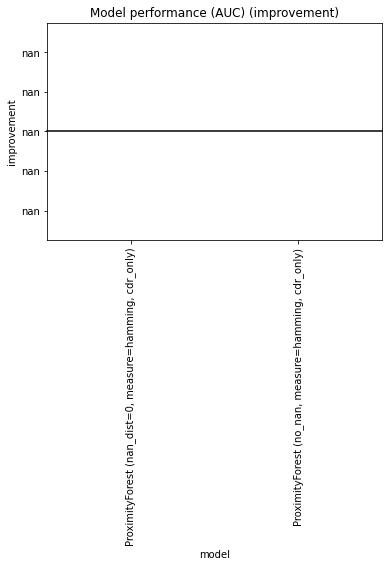

### Dataset size: 200 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 160, test: 108
No Nan: train: 40, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 155.90it/s]


0.71


Predicting: 100%|██████████| 100/100 [00:00<00:00, 157.36it/s]


0.71


Predicting: 100%|██████████| 100/100 [00:00<00:00, 169.20it/s]


0.7


Predicting: 100%|██████████| 100/100 [00:00<00:00, 164.76it/s]


0.71


Predicting: 100%|██████████| 100/100 [00:00<00:00, 169.53it/s]


0.72

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 160.63it/s]


0.66


Predicting: 100%|██████████| 100/100 [00:00<00:00, 155.76it/s]


0.67


Predicting: 100%|██████████| 100/100 [00:00<00:00, 162.73it/s]


0.61


Predicting: 100%|██████████| 100/100 [00:00<00:00, 169.80it/s]


0.64


Predicting: 100%|██████████| 100/100 [00:00<00:00, 160.86it/s]


0.6799999999999999
Finished evaluating 2 models at 20230527-081448 in 0:00:15.623248 seconds


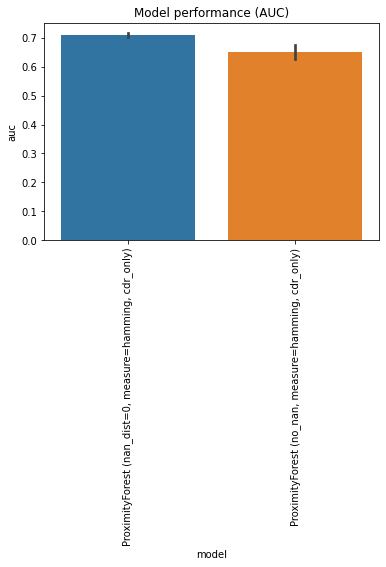

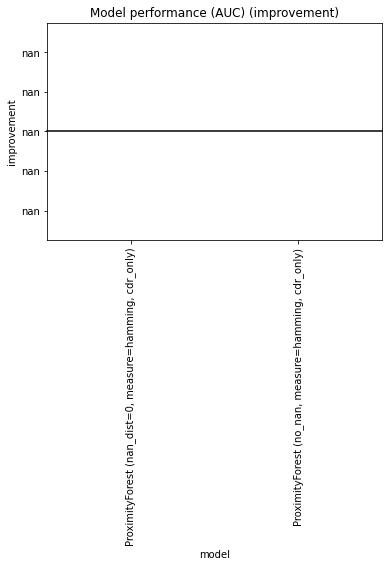

### Dataset size: 500 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 108
No Nan: train: 100, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 176.42it/s]


0.75


Predicting: 100%|██████████| 100/100 [00:00<00:00, 142.29it/s]


0.76


Predicting: 100%|██████████| 100/100 [00:00<00:00, 155.57it/s]


0.78


Predicting: 100%|██████████| 100/100 [00:00<00:00, 149.93it/s]


0.73


Predicting: 100%|██████████| 100/100 [00:00<00:00, 136.12it/s]


0.76

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 128.45it/s]


0.73


Predicting: 100%|██████████| 100/100 [00:00<00:00, 127.49it/s]


0.76


Predicting: 100%|██████████| 100/100 [00:00<00:00, 132.11it/s]


0.74


Predicting: 100%|██████████| 100/100 [00:00<00:00, 134.53it/s]


0.71


Predicting: 100%|██████████| 100/100 [00:00<00:00, 149.05it/s]


0.74
Finished evaluating 2 models at 20230527-081524 in 0:00:30.616387 seconds


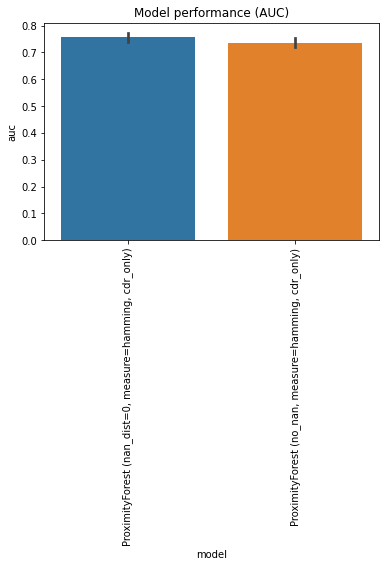

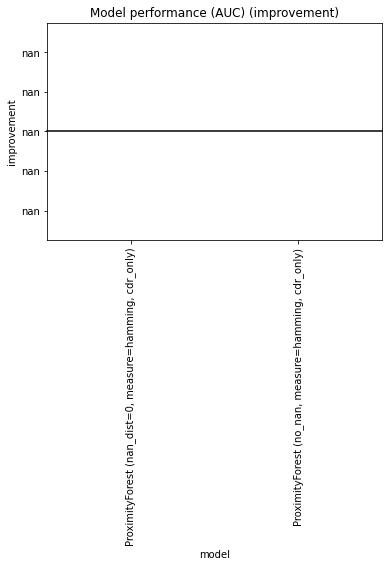

### Dataset size: 1000 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 800, test: 108
No Nan: train: 192, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 162.20it/s]


0.76


Predicting: 100%|██████████| 100/100 [00:00<00:00, 178.69it/s]


0.78


Predicting: 100%|██████████| 100/100 [00:00<00:00, 181.08it/s]


0.8200000000000001


Predicting: 100%|██████████| 100/100 [00:00<00:00, 166.70it/s]


0.8


Predicting: 100%|██████████| 100/100 [00:00<00:00, 171.08it/s]


0.79

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 176.07it/s]


0.75


Predicting: 100%|██████████| 100/100 [00:00<00:00, 176.39it/s]


0.79


Predicting: 100%|██████████| 100/100 [00:00<00:00, 167.77it/s]


0.79


Predicting: 100%|██████████| 100/100 [00:00<00:00, 167.22it/s]


0.8


Predicting: 100%|██████████| 100/100 [00:00<00:00, 181.56it/s]


0.79
Finished evaluating 2 models at 20230527-081622 in 0:00:46.781909 seconds


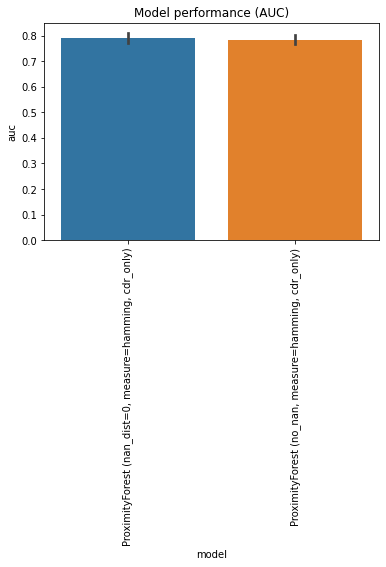

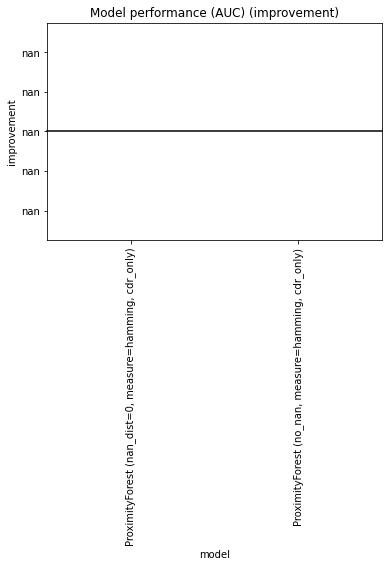

### Dataset size: 2000 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 1600, test: 108
No Nan: train: 432, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 172.74it/s]


0.85


Predicting: 100%|██████████| 100/100 [00:00<00:00, 162.69it/s]


0.8


Predicting: 100%|██████████| 100/100 [00:00<00:00, 160.51it/s]


0.8300000000000001


Predicting: 100%|██████████| 100/100 [00:00<00:00, 158.05it/s]


0.8400000000000001


Predicting: 100%|██████████| 100/100 [00:00<00:00, 166.73it/s]


0.8300000000000001

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 166.35it/s]


0.8400000000000001


Predicting: 100%|██████████| 100/100 [00:00<00:00, 151.57it/s]


0.87


Predicting: 100%|██████████| 100/100 [00:00<00:00, 175.35it/s]


0.85


Predicting: 100%|██████████| 100/100 [00:00<00:00, 152.33it/s]


0.87


Predicting: 100%|██████████| 100/100 [00:00<00:00, 143.82it/s]


0.85
Finished evaluating 2 models at 20230527-081804 in 0:01:28.938197 seconds


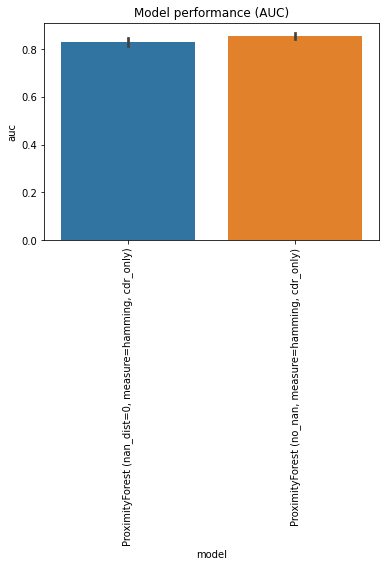

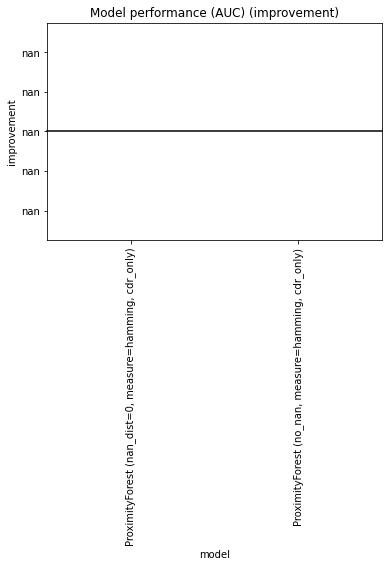

### Dataset size: 5000 ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 4000, test: 108
No Nan: train: 1102, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 185.16it/s]


0.9


Predicting: 100%|██████████| 100/100 [00:00<00:00, 177.99it/s]


0.9


Predicting: 100%|██████████| 100/100 [00:00<00:00, 142.02it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 177.38it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 179.04it/s]


0.9

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 161.50it/s]


0.9199999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 141.32it/s]


0.9199999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 165.39it/s]


0.9299999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 154.54it/s]


0.9199999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 164.64it/s]


0.9199999999999999
Finished evaluating 2 models at 20230527-082204 in 0:03:33.158156 seconds


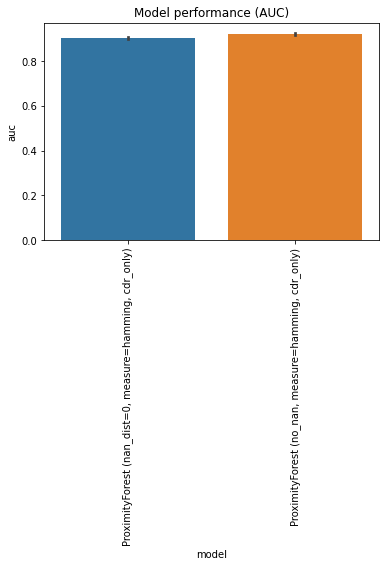

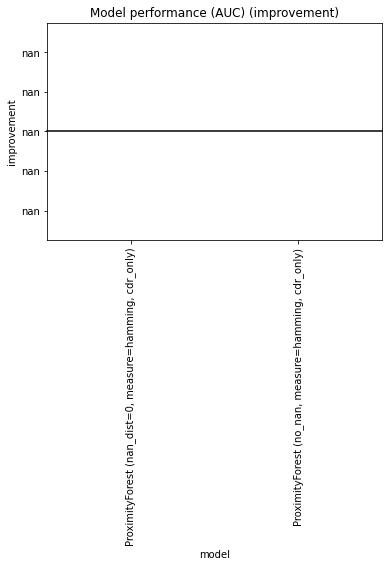

### Dataset size: None ###


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 10022, test: 108
No Nan: train: 2762, test: 108

Evaluating model 1/2
{'name': 'ProximityForest (nan_dist=0, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE384C0>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': False}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 147.14it/s]


0.95


Predicting: 100%|██████████| 100/100 [00:00<00:00, 170.34it/s]


0.9299999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 173.48it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 168.24it/s]


0.89


Predicting: 100%|██████████| 100/100 [00:00<00:00, 168.46it/s]


0.9299999999999999

Evaluating model 2/2
{'name': 'ProximityForest (no_nan, measure=hamming, cdr_only)', 'model': <util.proximityforest.ProximityForestClassifier object at 0x00000246AFE38370>, 'group': 'proximity_forest', 'extract_features': False, 'columns_to_use': ['CDR3'], 'drop_train_na': True}


Predicting: 100%|██████████| 100/100 [00:00<00:00, 167.47it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 154.17it/s]


0.95


Predicting: 100%|██████████| 100/100 [00:00<00:00, 142.11it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 150.77it/s]


0.9099999999999999


Predicting: 100%|██████████| 100/100 [00:00<00:00, 165.82it/s]


0.9099999999999999
Finished evaluating 2 models at 20230527-083206 in 0:09:02.543560 seconds


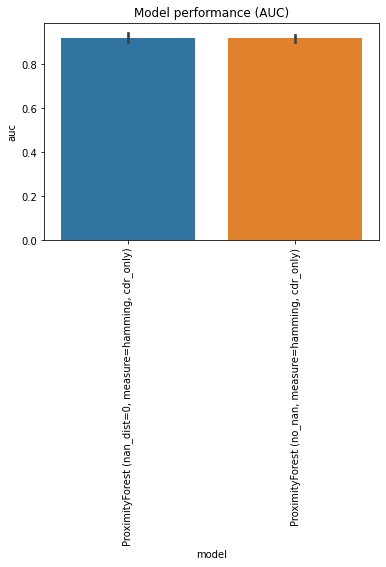

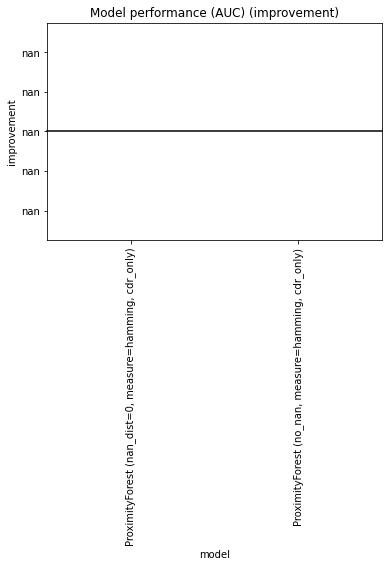

In [43]:
for dataset_size in [50, 100, 200, 500, 1000, 2000, 5000, None]:
    print(f"### Dataset size: {dataset_size} ###")
    update_data_per_fold(dataset_size)
    scores = evaluate_model_list(models_to_evaluate)
    plot_scores(scores, "Model performance (AUC)", baseline_name='RandomForest (only CDR3)')

In [44]:
models_to_evaluate = []